In [3]:
system("unzip Baltimore_Streets.zip")
system("unzip Baltimore_FastFood.zip")
system("unzip Baltimore_Junctions.zip")


In [5]:
library(spdep)
library(classInt)
library(rgdal)
library(RColorBrewer)
library(spatstat)
library(maptools)

Loading required package: sp
Loading required package: Matrix
rgdal: version: 1.2-16, (SVN revision 698)
 Geospatial Data Abstraction Library extensions to R successfully loaded
 Loaded GDAL runtime: GDAL 2.1.2, released 2016/10/24
 Path to GDAL shared files: /usr/share/gdal/2.1
 GDAL binary built with GEOS: TRUE 
 Loaded PROJ.4 runtime: Rel. 4.9.3, 15 August 2016, [PJ_VERSION: 493]
 Path to PROJ.4 shared files: (autodetected)
 Linking to sp version: 1.2-4 
Loading required package: nlme
Loading required package: rpart

spatstat 1.48-0       (nickname: ‘Model Prisoner’) 
For an introduction to spatstat, type ‘beginner’ 


Note: spatstat version 1.48-0 is out of date by more than a year; we strongly recommend upgrading to the latest version.
Checking rgeos availability: FALSE
 	Note: when rgeos is not available, polygon geometry 	computations in maptools depend on gpclib,
 	which has a restricted licence. It is disabled by default;
 	to enable gpclib, type gpclibPermit()


In [6]:
ff=readOGR( dsn= getwd() , layer="Baltimore_FastFood")
streets=readOGR( dsn= getwd() , layer="Baltimore_Streets")

OGR data source with driver: ESRI Shapefile 
Source: "/home/jovyan/food-network/food network", layer: "Baltimore_FastFood"
with 181 features
It has 11 fields
Integer64 fields read as strings:  OBJECTID Zip OBJECTID_1 
OGR data source with driver: ESRI Shapefile 
Source: "/home/jovyan/food-network/food network", layer: "Baltimore_Streets"
with 47460 features
It has 38 fields
Integer64 fields read as strings:  OBJECTID_1 OBJECTID_2 FRADDL TOADDL FRADDR TOADDR FRADDLA TOADDLA FRADDRA TOADDRA BLOCK_NUM 


In [7]:
head(ff@data, n=10)

OBJECTID,Type,Name,Address,City,State,County,Zip,X,Y,OBJECTID_1
66,Fast Food,Panda Express,6514 Reisterstown Rd,Baltimore,MD,Baltimore,21215,-8538549,4772880,66
69,Fast Food,Pizza Hut,6663 Belair Rd,Baltimore,MD,Baltimore City,21206,-8519336,4772626,69
72,Fast Food,A&W,6602 Reisterstown Rd,Baltimore,MD,Baltimore City,21215,-8538661,4772986,72
75,Fast Food,Blimpie,100 South Charles Street,Baltimore,MD,Baltimore City,21202,-8528750,4762965,75
76,Fast Food,Blimpie,600 N Wolfe St,Baltimore,MD,Baltimore City,21287,-8526059,4764366,76
77,Fast Food,Burger King,6605 Reisterstown Rd,Baltimore,MD,Baltimore City,21215,-8538652,4773000,77
78,Fast Food,Burger King,4400 Reisterstown Rd,Baltimore,MD,Baltimore City,21215,-8534640,4770333,78
79,Fast Food,Burger King,2301 Liberty Heights Ave,Baltimore,MD,Baltimore City,21215,-8533038,4767401,79
80,Fast Food,Burger King,1437 W Patapsco Ave,Baltimore,MD,Baltimore City,21230,-8531404,4757301,80
81,Fast Food,Burger King,1201 W North Ave,Baltimore,MD,Baltimore City,21217,-8531192,4766210,81


In [8]:
#this is the Maryland projection from Arc
proj4string(ff)


[1] "+proj=lcc +lat_1=38.3 +lat_2=39.45 +lat_0=37.66666666666666 +lon_0=-77 +x_0=399999.9998983998 +y_0=0 +datum=NAD83 +units=us-ft +no_defs +ellps=GRS80 +towgs84=0,0,0"

In [9]:
sapply(ff@data, class)
nrow(ff)
ncol(ff)

OBJECTID       Type       Name    Address       City      State     County 
  "factor"   "factor"   "factor"   "factor"   "factor"   "factor"   "factor" 
       Zip          X          Y OBJECTID_1 
  "factor"  "numeric"  "numeric"   "factor"

[1] 181

[1] 11

In [122]:
summary(ff)

Object of class SpatialPointsDataFrame
Coordinates:
                min       max
coords.x1 1394250.4 1445098.7
coords.x2  571863.8  618467.8
Is projected: TRUE 
proj4string :
[+proj=lcc +lat_1=38.3 +lat_2=39.45 +lat_0=37.66666666666666 +lon_0=-77
+x_0=399999.9998983998 +y_0=0 +datum=NAD83 +units=us-ft +no_defs
+ellps=GRS80 +towgs84=0,0,0]
Number of points: 181
Data attributes:
    OBJECTID          Type                         Name   
 100    :  1   Fast Food:181   Subway                :49  
 101    :  1                   McDonald's            :25  
 102    :  1                   Dunkin' Donuts        :21  
 103    :  1                   New York Fried Chicken:17  
 104    :  1                   Burger King           :13  
 105    :  1                   KFC                   :11  
 (Other):175                   (Other)               :45  
                     Address              City     State   
 600 N Wolfe St          :  3   Baltimore   :176   MD:181  
 1100 Light St           : 

In [160]:
summary(ff$Name)

A&W                Blimpie            Burger King 
                     1                      2                     13 
              Checkers             Chik-Fil-A         Dunkin' Donuts 
                     2                      1                     21 
             Five Guys Hip Hop Fish & Chicken            Jimmy Johns 
                     2                      3                      2 
                   KFC      Long John Silvers             McDonald's 
                    11                      3                     25 
 Moe's Southwest Grill New York Fried Chicken    Noble Roman's Pizza 
                     1                     17                      1 
         Panda Express              Pizza Hut               Popeye's 
                     1                      1                      9 
               Quiznos         Sonic Drive-In                 Subway 
                     3                      1                     49 
             Taco Bell                Wendy's               Wingstop 
                     4                      7                      1

In [161]:
win <- owin(c(1393352.4, 1455893.1), c(558087.1, 622329.7))
summary(win)
FF0 <- as.ppp(coordinates(ff), win, marks=ff$Name)

Window: rectangle = [1393352.4, 1455893.1] x [558087.1, 622329.7] units
Window area = 4017780000 square units

Warning message in ppp(X[, 1], X[, 2], window = win, check = check):
“data contain duplicated points”

In [162]:
summary(coordinates(ff))

   coords.x1         coords.x2     
 Min.   :1394250   Min.   :571864  
 1st Qu.:1412562   1st Qu.:589784  
 Median :1421288   Median :593695  
 Mean   :1420137   Mean   :596490  
 3rd Qu.:1426195   3rd Qu.:603215  
 Max.   :1445099   Max.   :618468  

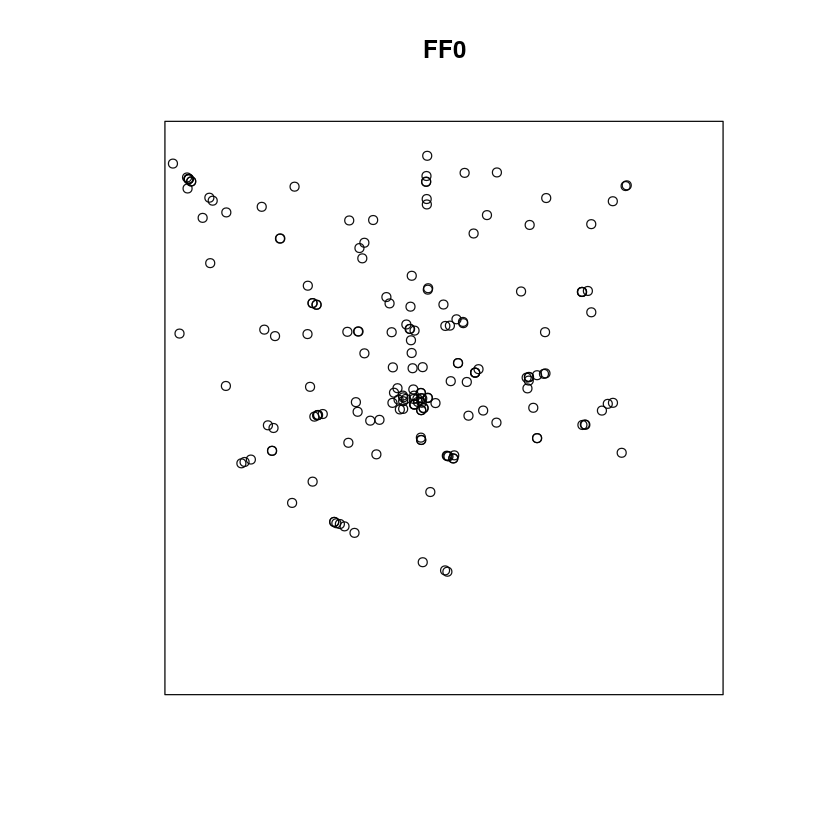

In [163]:
plot(FF0)

In [164]:
L0 <- as.linnet.SpatialLines(streets)

In [165]:
summary(L0)

Linear network with 144189 vertices and 160259 lines
Total length 11440160 units
Maximum vertex degree: 8
[Sparse matrix representation]
Numerical tolerance: 4.277684e-06 units
Enclosing window: rectangle = [1393352.4, 1455893.1] x [558087.1, 622329.7] 
units

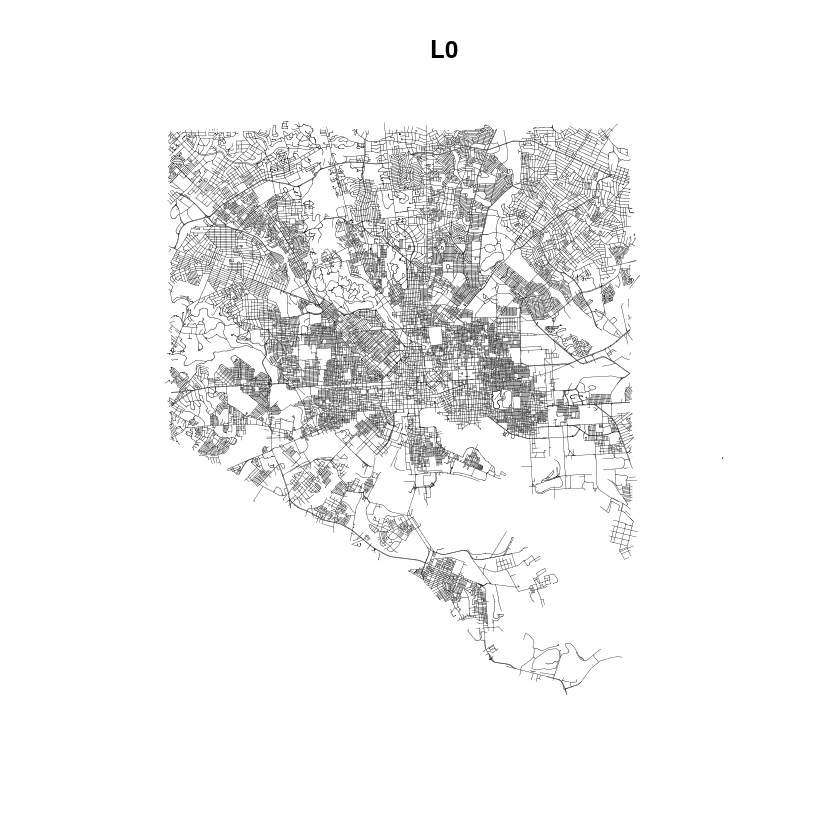

In [166]:
plot(L0, fill=TRUE, bg="skyblue", lwd=0.25, mar=rep(0,4), border=0 )

In [167]:
FFL <- lpp(FF0, L0)

In [171]:
summary(FFL)

Point pattern on linear network
181 points
Linear network with 144189 vertices and 160259 lines
Total length 11440160 units
Average intensity 1.582146e-05 points per unit length
Enclosing window: rectangle = [1393352.4, 1455893.1] x [558087.1, 622329.7] 
units

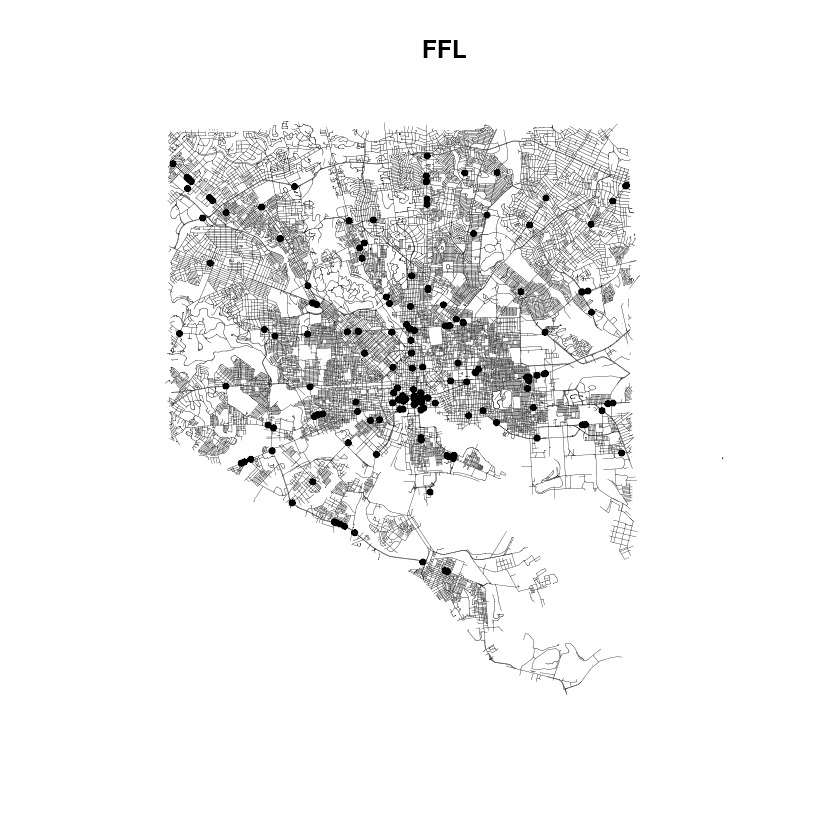

In [177]:
plot(FFL,fill=TRUE, bg="skyblue", lwd=0.25, mar=rep(0,4), border=0, pch=19, cex=.75)